Model and Data Loading

In [1]:
# Initate Model and Load Data
"""
This code uses the Planning Operator on the Maze dataset described in the paper "Planning Operator: Generalizable Robot Motion Planning via Operator Learning"
"""

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt

import matplotlib.pyplot as plt
from utilities import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import os
import sys
from itertools import chain

# Helpers:

class ConstrainedLinear(nn.Linear):
  def forward(self, x):
    return F.linear(x, torch.min(self.weight ** 2, torch.abs(self.weight)))

# Activations:

class MaxReLUPairwiseActivation(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weights = nn.Parameter(torch.zeros(1, num_features))
    self.avg_pool = nn.AvgPool1d(2, 2)

  def forward(self, x):
    x = x.unsqueeze(1)
    max_component = F.max_pool1d(x, 2)
    relu_component = F.avg_pool1d(F.relu(x * F.softplus(self.weights)), 2)
    output = torch.cat((max_component, relu_component), dim=-1).squeeze(1)
    return output


class MaxAvgGlobalActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.alpha = nn.Parameter(-torch.ones(1))

  def forward(self, x):
    alpha = torch.sigmoid(self.alpha)
    return alpha * x.max(dim=-1)[0] + (1 - alpha) * x.mean(dim=-1)


class MaxPoolPairwiseActivation(nn.Module):
  def forward(self, x):
    x = x.unsqueeze(1)
    x = F.max_pool1d(x, 2)
    return x.squeeze(1)


class ConcaveActivation(nn.Module):
  def __init__(self, num_features, concave_activation_size):
    super().__init__()
    assert concave_activation_size > 1

    self.bs_nonzero = nn.Parameter(1e-3 * torch.randn((1, num_features, concave_activation_size - 1)) - 1)
    self.bs_zero    = torch.zeros((1, num_features, 1))
    self.ms = nn.Parameter(1e-3 * torch.randn((1, num_features, concave_activation_size)))

  def forward(self, x):
    bs = torch.cat((F.softplus(self.bs_nonzero), self.bs_zero), -1)
    ms = 2 * torch.sigmoid(self.ms)
    x = x.unsqueeze(-1)

    x = x * ms + bs
    return x.min(-1)[0]


# Metrics:

class ReduceMetric(nn.Module):
  def __init__(self, mode):
    super().__init__()
    if mode == 'avg':
      self.forward = self.avg_forward
    elif mode == 'max':
      self.forward = self.max_forward
    elif mode == 'maxavg':
      self.maxavg_activation = MaxAvgGlobalActivation()
      self.forward = self.maxavg_forward
    else:
      raise NotImplementedError

  def maxavg_forward(self, x):
    return self.maxavg_activation(x)

  def max_forward(self, x):
    return x.max(-1)[0]

  def avg_forward(self, x):
    return x.mean(-1)


class EuclideanMetric(nn.Module):
  def forward(self, x, y):
    return torch.norm(x - y, dim=-1)


class MahalanobisMetric(nn.Module):
  def __init__(self, num_features, size):
    super().__init__()
    self.layer = nn.Linear(num_features, size, bias=False)

  def forward(self, x, y):
    return torch.norm(self.layer(x - y), dim=-1)


class WideNormMetric(nn.Module):
  def __init__(self,
               num_features,
               num_components,
               component_size,
               concave_activation_size=None,
               mode='avg',
               symmetric=True):
    super().__init__()
    self.symmetric = symmetric
    self.num_components = num_components
    self.component_size = component_size

    output_size = component_size*num_components
    if not symmetric:
      num_features = num_features * 2
      self.f = ConstrainedLinear(num_features, output_size)
    else:
      self.f = nn.Linear(num_features, output_size)
      
    self.activation = ConcaveActivation(num_components, concave_activation_size) if concave_activation_size else nn.Identity()
    self.reduce_metric = ReduceMetric(mode)

  def forward(self, x, y):
    h = x - y
    if not self.symmetric:
      h = torch.cat((F.relu(h), F.relu(-h)), -1)
    h = torch.reshape(self.f(h), (-1, self.num_components, self.component_size))
    h = torch.norm(h, dim=-1)
    h = self.activation(h)
    return self.reduce_metric(h)


class DeepNormMetric(nn.Module):
  def __init__(self, num_features, layers, activation=nn.ReLU, concave_activation_size=None, mode='avg', symmetric=False):
    super().__init__()
    self.num_features = num_features

    assert len(layers) >= 2

    self.Us = nn.ModuleList([nn.Linear(num_features, layers[0], bias=False)])
    self.Ws = nn.ModuleList([])

    for in_features, out_features in zip(layers[:-1], layers[1:]):
      self.Us.append(nn.Linear(num_features, out_features, bias=False))
      self.Ws.append(ConstrainedLinear(in_features, out_features, bias=False))

    self.activation = activation()
    self.output_activation = ConcaveActivation(layers[-1], concave_activation_size) if concave_activation_size else nn.Identity()
    self.reduce_metric = ReduceMetric(mode)

    self.symmetric = symmetric

  def _asym_fwd(self, h):
    h1 = self.Us[0](h)
    for U, W in zip(self.Us[1:], self.Ws):
      h1 = self.activation(W(h1) + U(h))
    return h1

  def forward(self, x, y):
    h = x - y
    if self.symmetric:
      h = self._asym_fwd(h) + self._asym_fwd(-h)
    else:
      h = self._asym_fwd(-h)
    h = self.activation(h)
    return self.reduce_metric(h)


################################################################
# fourier layer
################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class PlanningOperator2D(nn.Module):
    def __init__(self, modes1, modes2, width, nlayers):
        super(PlanningOperator2D, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.inp_size = 2
        self.nlayers = nlayers

        self.fc0 = nn.Linear(self.inp_size, self.width)

        for i in range(self.nlayers):
            self.add_module('conv%d' % i, SpectralConv2d(self.width, self.width, self.modes1, self.modes2))
            self.add_module('w%d' % i, nn.Conv2d(self.width, self.width, 1))

        self.fc1 =  DeepNormMetric(self.width, (128, 128), concave_activation_size=20, activation=lambda: MaxReLUPairwiseActivation(128), symmetric=True)

    def forward(self, chi, gs):
        batchsize = chi.shape[0]
        size_x = size_y = chi.shape[1]

        grid = self.get_grid(batchsize, size_x, size_y, chi.device)

        chi = chi.permute(0, 3, 1, 2)
        chi = chi.expand(batchsize, self.width, size_x, size_y)
        x = grid

        # Lifting layer:
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        for i in range(self.nlayers):
            conv_chi = self._modules['conv%d' % i](chi)
            conv_chix = self._modules['conv%d' % i](chi * x)
            xconv_chi = x * conv_chi
            wx = self._modules['w%d' % i](x)
            x = chi * (conv_chix - xconv_chi + wx)
            if i < self.nlayers - 1: x = F.gelu(x)

        x = x.permute(0, 2, 3, 1)

        # print(gs.shape)

        g = x.clone()
        x1 = x.clone()

        for i in range(batchsize):
                g[i, :, :, :] = x1[i, int(gs[i,0,0]), int(gs[i,1,0]), :]

        feature1 = g
        feature2 = x1
        reshapedfeature1 = feature1.reshape(-1,self.width)
        reshapedfeature2 = feature2.reshape(-1,self.width)
        output = self.fc1(reshapedfeature1,reshapedfeature2)
        reshapedoutput = output.reshape(batchsize,size_x,size_y,1)

        return reshapedoutput

    def get_grid(self, batchsize, size_x, size_y, device):
        gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


def scheduler(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer


def LR_schedule(learning_rate, steps, scheduler_step, scheduler_gamma):
    return learning_rate * np.power(scheduler_gamma, (steps // scheduler_step))


def smooth_chi(mask, dist, smooth_coef):
    return torch.mul(torch.tanh(dist * smooth_coef), (mask - 0.5)) + 0.5



lrs = [8e-3]
gammas = [0.5]
wds = [3e-6]
smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds
seeds = [5, 2000, 14000, 16000, 100000]
seeds = [seeds[0]]

################################################################
#                       configs
################################################################
Ntotal = 5054*10+1000*10
ntrain = 5054*10
ntest = Ntotal-ntrain

batch_size = 20

epochs = 501
scheduler_step = 100
tol_early_stop = 500

modes = 8
width = 32
nlayers = 5

################################################################
# load data and data normalization
################################################################
t1 = default_timer()

sub = 1
Sx = int(((28 - 1) / sub) + 1)
Sy = Sx

mask = np.load('./vin_dataset_27x27/mask.npy')
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('./vin_dataset_27x27/dist_in.npy')
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
# input = mask

output = np.load('./vin_dataset_27x27/output.npy')
output = torch.tensor(output, dtype=torch.float)

goals = np.load('./vin_dataset_27x27/goals.npy')
goals = torch.tensor(goals, dtype=torch.float)


mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

mask_train = mask_train.reshape(ntrain, Sx, Sy, 1)
mask_test = mask_test.reshape(ntest, Sx, Sy, 1)

chi_train = input[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
chi_test = input[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

chi_train = chi_train.reshape(ntrain, Sx, Sy, 1)
chi_test = chi_test.reshape(ntest, Sx, Sy, 1)

y_train = output[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
y_test = output[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

y_train = y_train.reshape(ntrain, Sx, Sy, 1)
y_test = y_test.reshape(ntest, Sx, Sy, 1)

goals_train = goals[:ntrain]
goals_test = goals[-ntest:]

goals_train = goals_train.reshape(ntrain, 2, 1)
goals_test = goals_test.reshape(ntest, 2, 1)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                          batch_size=batch_size,
                                          shuffle=False)



In [2]:


model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("planningoperator_vin_maze27x27_symmetric_norm/n50540_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



PlanningOperator2D(
  (fc0): Linear(in_features=2, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv1): SpectralConv2d()
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2): SpectralConv2d()
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): SpectralConv2d()
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv4): SpectralConv2d()
  (w4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Plotting all predictions against ground truth

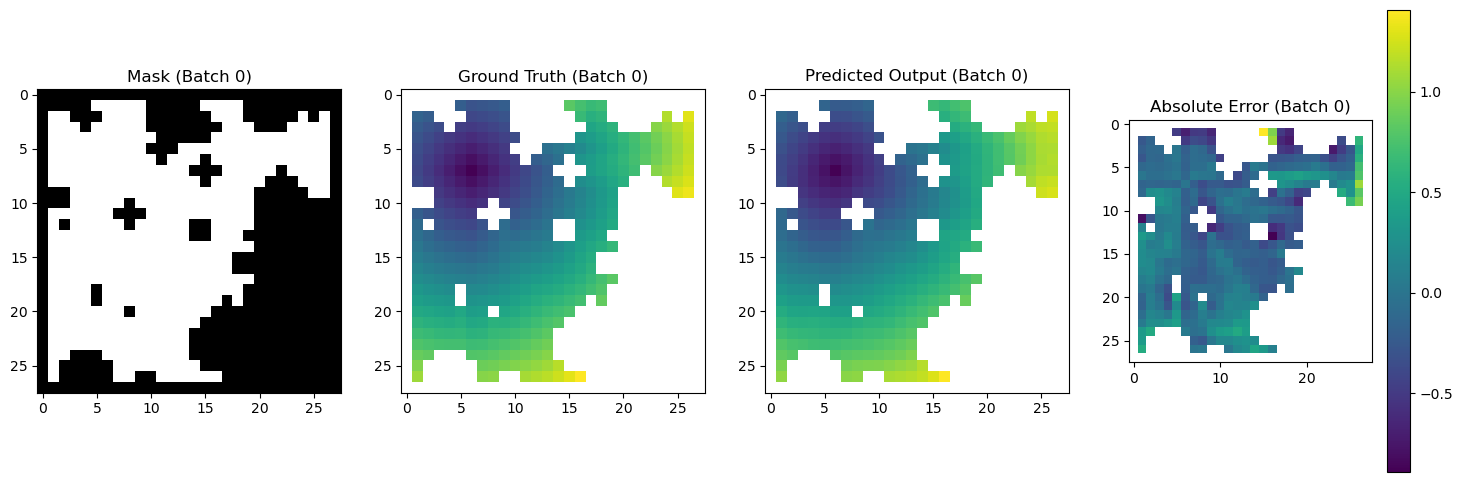

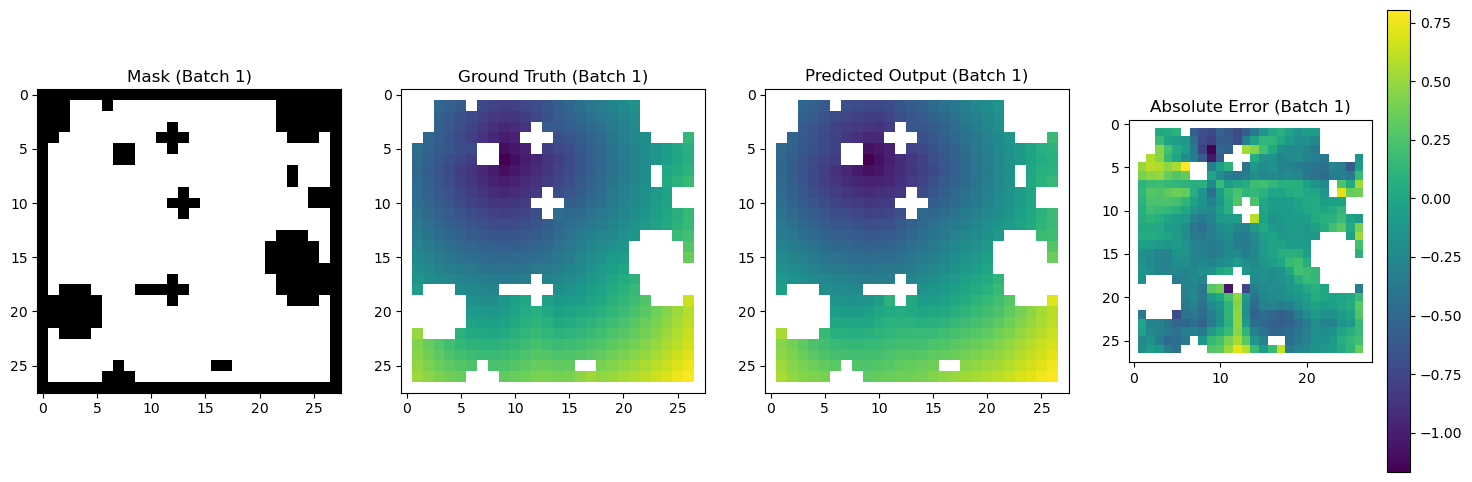

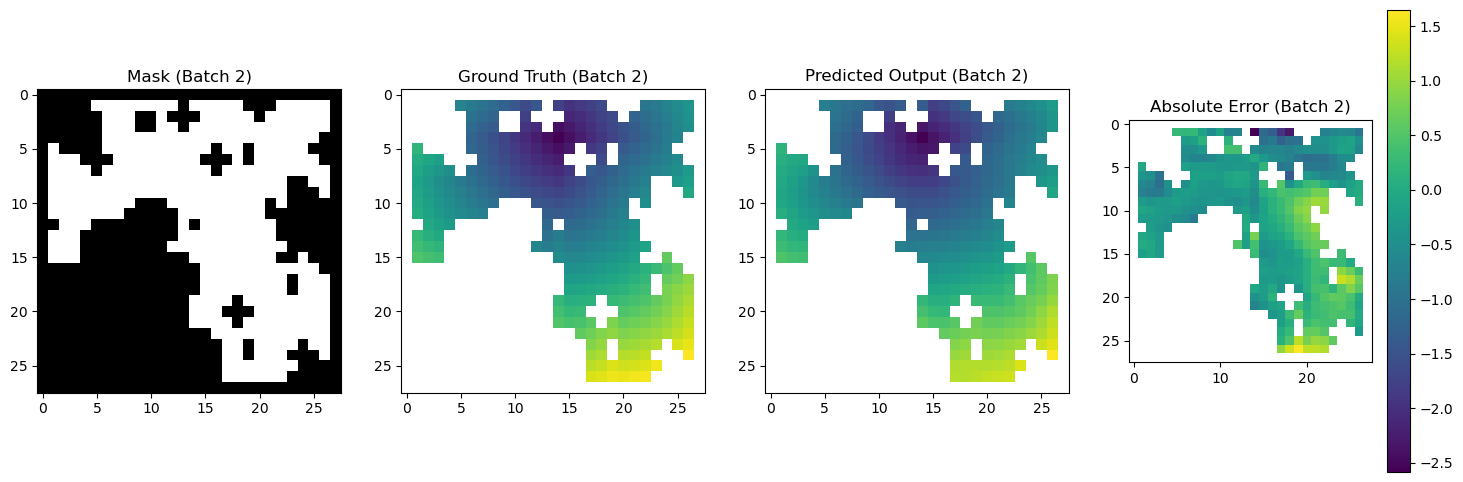

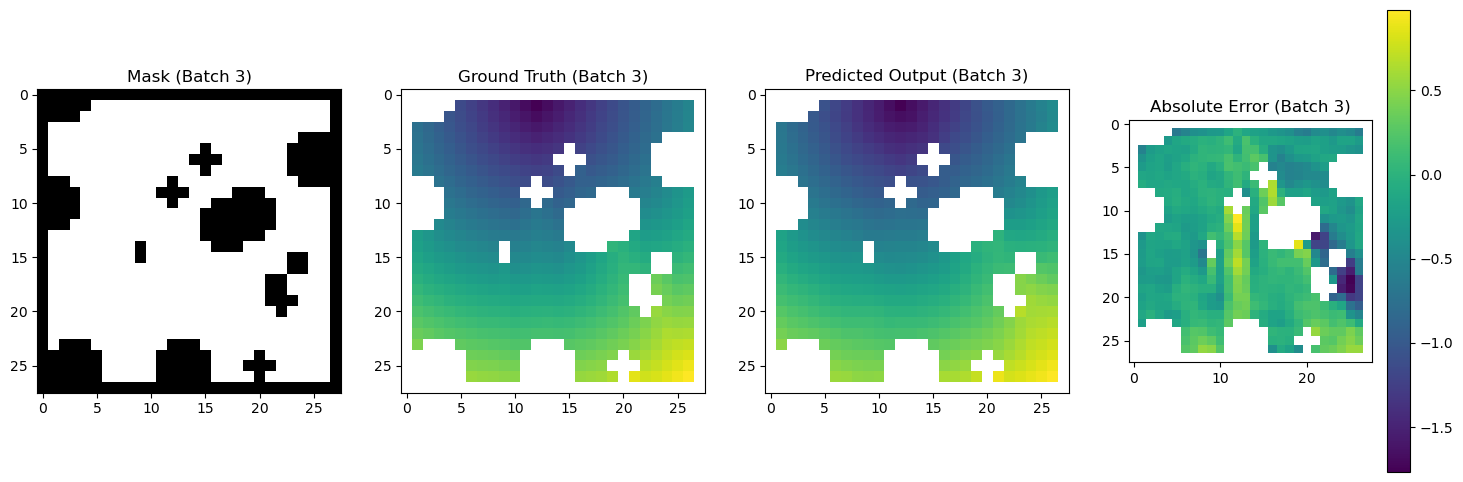

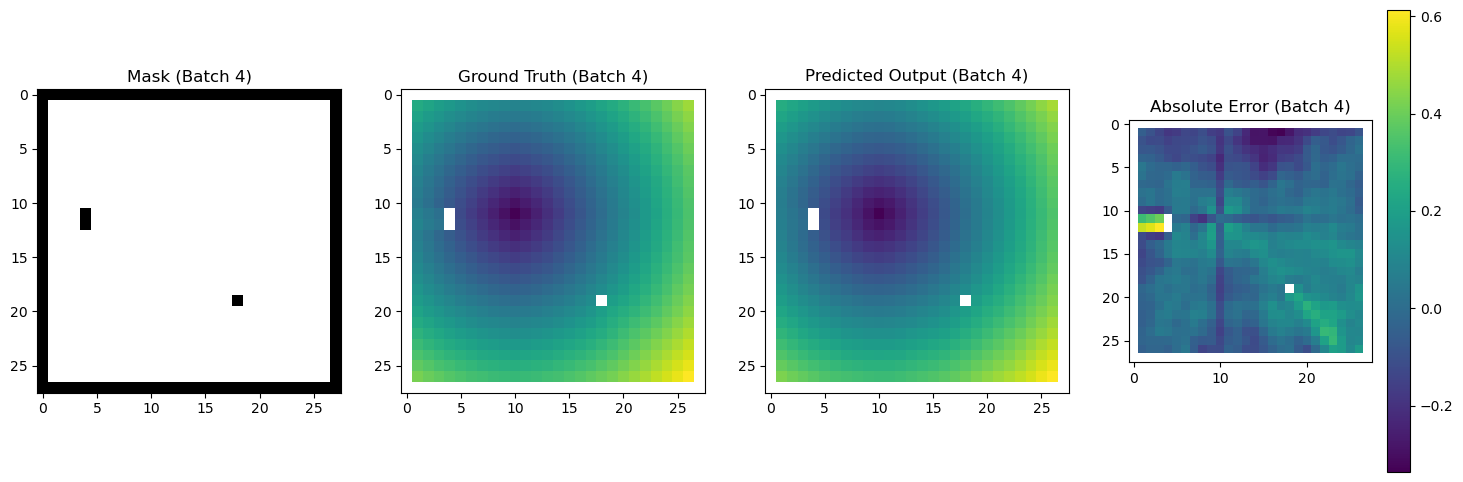

In [3]:
mean_error = 0
count = 0
normalization = 1/1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output) 
        ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
        absolute_error = (ground_truth - predicted_output * normalization)
        if batch_id == 5:
            break

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        titles = ['Mask', 'Ground Truth', 'Predicted Output', 'Absolute Error']
        images = [
            mask[0, :, :, 0].cpu().numpy(),
            ground_truth[0, :, :, 0].cpu().numpy(),
            predicted_output[0, :, :, 0].cpu().numpy(),
            absolute_error[0, :, :, 0].cpu().numpy()
        ]
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(images[i], cmap='viridis' if i > 0 else 'gray')
            plt.title(f'{titles[i]} (Batch {batch_id})')
            if i == 3:
                plt.colorbar()
        plt.show()


Gradient Descent Function Definition

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


action_vecs = np.asarray([[-1., 0.], [1., 0.], [0., 1.], [0., -1.],
                            [-1., 1.], [-1., -1.], [1., 1.], [1., -1.]])

#   # Create a custom colormap that is inverted
cmap = plt.cm.viridis  # Choose the colormap you want to invert
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))

import numpy as np
import matplotlib.pyplot as plt


def perform_gradient_descent(value_function, start_point, learning_rate, num_steps, goal_point, plotsuccess = False,plotfails = False):
    if(plotsuccess or plotfails):
        plt.figure(figsize=(8, 8))
        plt.imshow(value_function, cmap=cmap_inverted, vmin=0, vmax=50, aspect='equal', origin='lower')  # Transpose value_function
        plt.colorbar()
    path_length = 0

    path_points = [start_point.copy()]
    visited_points = set()

    current_point = start_point.copy()

    for step in range(num_steps):
        best_gradient = np.inf
        best_action = None

        for action in action_vecs:
            new_point = current_point + learning_rate * action
            new_point_indices = np.round(new_point).astype(int)
            x_index, y_index = new_point_indices[0], new_point_indices[1]

            if (0 <= x_index < value_function.shape[0] and 0 <= y_index < value_function.shape[1] and
                    (x_index, y_index) not in visited_points):
                gradient = value_function[x_index, y_index]  # Note the change here
                if gradient < best_gradient:
                    best_gradient = gradient
                    best_action = action

        if best_gradient > 100:
            if plotfails:
                plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2)  # Reversed plotting
                plt.gca().set_aspect('equal', adjustable='box')
                plt.show()
            return False, 0  

        if best_action is not None:
            current_point += learning_rate * best_action
            path_length += np.linalg.norm(learning_rate * best_action)
            path_points.append(current_point.copy())
            visited_points.add(tuple(np.round(current_point).astype(int)))
            if np.array_equal(np.round(current_point).astype(int), np.round(goal_point).astype(int)):
                if plotsuccess:
                    plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2)  # Reversed plotting
                    plt.gca().set_aspect('equal', adjustable='box')
                    plt.show()
                return True, path_length  # Success
        else:
            if plotfails:
                plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2)  # Reversed plotting
                plt.gca().set_aspect('equal', adjustable='box')
                plt.show()
            return False, 0  # No valid action found
    if plotfails:    
        plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2)  # Reversed plotting
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()        
    return False, 0  

In [5]:
def calculate_signed_distance(velocity_matrix):
    # Find the indices of obstacles
    obstacle_indices = np.where(velocity_matrix == 0)

    # Check if there are no obstacles
    if obstacle_indices[0].size == 0:
        # Handle the case when there are no obstacles
        return np.zeros_like(velocity_matrix)

    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(velocity_matrix.shape[1]), np.arange(velocity_matrix.shape[0]), indexing='ij')  # Note the change in the order of indices
    
    # Calculate distances to obstacles using vectorized operations
    distances = np.sqrt((obstacle_indices[0][:, None, None] - i[None, :, :])**2 + (obstacle_indices[1][:, None, None] - j[None, :, :])**2)

    # Find the minimum distance for each point
    signed_distance = np.min(distances, axis=0)
    return signed_distance


In [6]:
success_count = 0
count = 0
averagepath = 0
start_positions = []
nodesexplored = 0

from scipy.io import loadmat
testing_data_28x28 = loadmat('gridworld_28_test.mat')
testing_data_28x28_maps = testing_data_28x28["all_im_data"]
testing_data_28x28 = testing_data_28x28["all_states_xy"]

# output = predicted_output
for batch_idx, (mask, chi, ground_truth, gg) in enumerate(test_loader):
    ss = gg.clone()
    gg1 = gg.clone()
    for i in range(0,10):
        temp_tensor = torch.from_numpy(testing_data_28x28[2*batch_idx][0][-1].reshape(2,1))
        gg1[i, :] = torch.flip(temp_tensor, dims=[0])-1
        temp_tensor = torch.from_numpy(testing_data_28x28[2*batch_idx][0][0].reshape(2,1))
        ss[i, :] = torch.flip(temp_tensor, dims=[-1])-1
    for i in range(10,20):
        temp_tensor = torch.from_numpy(testing_data_28x28[(2*batch_idx+1)][0][-1].reshape(2,1))
        gg1[i, :] = torch.flip(temp_tensor, dims=[0])-1
        temp_tensor = torch.from_numpy(testing_data_28x28[(2*batch_idx+1)][0][0].reshape(2,1))
        ss[i, :] = torch.flip(temp_tensor, dims=[-1])-1    

    mask, chi, ground_truth, gg, gg1 = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device), gg1.to(device)
    predicted_output = model(chi,gg1)

    predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
    ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)

    value_function = predicted_output[0,:,:,0].cpu().detach().numpy()
    start_point = np.flip(ss[0,:,0].cpu().detach().numpy())
    learning_rate = 1
    num_steps = 100
    goal = gg1[0,:,0].cpu().detach().numpy()
    goal = [goal[0],goal[1]]
    success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)

    if(success):
        success_count+=1
    else:
        
        perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)
        failedmask = testing_data_28x28_maps.reshape(1000,28,28)[2*batch_idx,:,:]
        failedsdf = calculate_signed_distance(failedmask)

        failedmask = torch.tensor(failedmask, dtype=torch.float)
        failedmask = failedmask.unsqueeze(0).unsqueeze(-1).expand(20, 28, 28, 1)

        failedsdf = torch.tensor(failedsdf, dtype=torch.float)
        failedsdf = failedsdf.unsqueeze(0).unsqueeze(-1).expand(20, 28, 28, 1)
        input = smooth_chi(failedmask, failedsdf, smooth_coef)
        input = input.to(device)
        failedmask = failedmask.to(device)
        failed_out = model(input,gg1)
        failed_out = torch.where(failedmask == 0, torch.tensor(float('inf')), failed_out)

        value_function = failed_out[0,:,:,0].cpu().detach().numpy()
        success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)
        if(success):
            # print("Map Number:", batch_idx*2)
            success_count+=1
        else:
            # print("Map Number:", batch_idx*2)
            # print("Start:",start_point,"Goal:",goal)
            # print("Plotting Failed Scenario")
            success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)    

    count+=1

    value_function = predicted_output[10,:,:,0].cpu().detach().numpy()
    start_point = np.flip(ss[10,:,0].cpu().detach().numpy())
    learning_rate = 1
    num_steps = 100
    goal = gg1[10,:,0].cpu().detach().numpy()
    goal = [goal[0],goal[1]]
    success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)
    if(success):
        success_count+=1
    else:
        
        perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)
        failedmask = testing_data_28x28_maps.reshape(1000,28,28)[(2*batch_idx)+1,:,:]
        failedsdf = calculate_signed_distance(failedmask)

        failedmask = torch.tensor(failedmask, dtype=torch.float)
        failedmask = failedmask.unsqueeze(0).unsqueeze(-1).expand(20, 28, 28, 1)


        failedsdf = torch.tensor(failedsdf, dtype=torch.float)
        failedsdf = failedsdf.unsqueeze(0).unsqueeze(-1).expand(20, 28, 28, 1)
        input = smooth_chi(failedmask, failedsdf, smooth_coef)
        input = input.to(device)
        failedmask = failedmask.to(device)

        failed_out = model(input,gg1)
        failed_out = torch.where(failedmask == 0, torch.tensor(float('inf')), failed_out)

        value_function = failed_out[10,:,:,0].cpu().detach().numpy()
        success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)
        if(success):
            # print("Map Number:", (batch_idx*2)+1)
            success_count+=1
        else:
            # print("Map Number:", ((batch_idx*2)+1))
            # print("Start:",start_point,"Goal:",goal)
            # print("Plotting Failed Scenario")
            success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)      
    count+=1

print("Success Rate:",(success_count/count)*100,"%")



Success Rate: 99.3 %


In [ ]:
def bidirectional_planning(start, model, goal, chi):
 reached = False
 num_steps = 0

 current_start_point = start.copy()
 current_goal_point = goal.copy()

 action_vecs = np.asarray([[-1., 0.], [1., 0.], [0., 1.], [0., -1.],
                            [-1., 1.], [-1., -1.], [1., 1.], [1., -1.]])
 
 gg = goal
 ss = start

 while reached or (num_steps < 1000):
    chi = chi
    ss = start 
    gg = goal

    ss = gg.clone()
    gg1 = gg.clone()

    for i in range(0,20):
        temp_tensor = torch.from_numpy(current_goal_point.reshape(2,1))
        gg1[i, :] = torch.flip(temp_tensor, dims=[0])
        
        temp_tensor = torch.from_numpy(current_start_point.reshape(2,1))
        ss[i, :] = torch.flip(temp_tensor, dims=[-1])

    valuefunctiongg = model(chi,gg)[0,:,:,0]
    valuefunctionss = model(chi,ss)[0,:,:,0]

    valuefunctiongg = torch.where(mask == 0, torch.tensor(float('inf')), valuefunctiongg)
    valuefunctionss = torch.where(mask == 0, torch.tensor(float('inf')), valuefunctionss)

    valuefunctiongg = valuefunctiongg.cpu().detach().numpy()
    valuefunctionss = valuefunctionss.cpu().detach().numpy()

    best_gradient_ss, best_gradient_gg = np.inf
    best_action_ss, best_action_gg = None

    path_ss_points = [current_start_point.copy()]
    path_gg_points = [current_goal_point.copy()]

    for action in action_vecs:
        new_point_ss = current_start_point + action
        new_point_gg = current_goal_point + action

        path_ss_points.append(new_point_ss.cop)

        new_point_ss_indices = np.round(new_point_ss).astype(int)
        x_ss_index, y_ss_index = new_point_ss_indices[0], new_point_ss_indices[1]

        new_point_gg_indices = np.round(new_point_gg).astype(int)
        x_gg_index, y_gg_index = new_point_gg_indices[0], new_point_gg_indices[1]

        if (0 <= x_ss_index < valuefunctionss.shape[0] and 0 <= y_ss_index < valuefunctionss.shape[1]):
            gradientss = valuefunctionss[x_ss_index, y_ss_index]  
            if gradientss < best_gradient_ss:
                best_gradient_ss = gradientss
                best_action_ss = action

        if (0 <= x_gg_index < valuefunctiongg.shape[0] and 0 <= y_gg_index < valuefunctiongg.shape[1]):
            gradientgg = valuefunctiongg[x_gg_index, y_gg_index] 
            if gradientgg < best_gradient_gg:
                best_gradient_gg = gradientgg
                best_action_gg = action                    

        if best_gradient_ss and best_gradient_gg > 1000: 
            return False

    if (best_action_ss and best_action_gg is not None):
        current_start_point = current_start_point + best_action_ss
        current_goal_point = current_goal_point + best_action_gg
        num_steps+=1

        path_ss_points.append(current_start_point.copy())
        path_gg_points.append(current_goal_point.copy())

        if np.array_equal(np.round(current_start_point).astype(int), np.round(current_goal_point).astype(int)):
            reached = True
            return True  
        else:
            return False # No valid action found
        
    return False, 0  





Testing Triangular Inequality

In [6]:
import random
success_count = 0
count = 0
for batch_idx, (mask, chi, ground_truth, gg) in enumerate(test_loader):
    count+=1
    mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
    predicted_output = model(chi,gg)
    predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
    ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
    passable_indices = np.argwhere(mask[0,:,:,0].cpu().numpy() == 1)
    dg1p = dg2p = dg1g2 = float("inf")
    while (dg1p>10e6) and (dg2p>10e6) and (dg1g2>10e6):
        random_index = random.choice(passable_indices)
        dg1p = predicted_output[0,random_index[0],random_index[1],0]
        dg2p = predicted_output[1,random_index[0],random_index[1],0]
        dg1g2 = predicted_output[0,int(gg[1,0,0]),int(gg[1,1,0]),0]
           
    if(torch.round(dg1p,decimals=2) <= torch.round(dg2p,decimals=2) + torch.round(dg1g2,decimals=2)) and (torch.round(dg1g2, decimals=2) <= torch.round(dg2p,decimals=2) + torch.round(dg1p, decimals=2)) and (torch.round(dg2p,decimals=2) <= torch.round(dg1p,decimals=2) + torch.round(dg1g2, decimals=2)):
        success_count+=1
    else:
        print("Does not follow triangular inequality")
        break    

    
print(success_count/count)        

1.0
